In [2]:
"""
Classification on CIFAR10 (ResNet)
==================================

Based on pytorch example for CIFAR10
"""


import sys
from pathlib import Path 
sys.path.append(str(Path.cwd().parent.parent))
import torch.optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from kymatio import Scattering2D
import matplotlib.pyplot as plt
import torch
import torch.fft
import argparse
import kymatio.datasets as scattering_datasets
from kymatio.scattering2d.core.scattering2d import scattering2d
import torch.nn as nn
from numpy.random import RandomState
import numpy as np
import pickle
import time
import mlflow
import os
from examples.utils.context import get_context
from examples.utils.wavelet_visualization import get_filters_visualization
from pathlib import Path
import yaml
import os
import sys


In [11]:
class Identity(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
    def forward(self, x):
        return x


class LinearLayer(nn.Module):
    def __init__(self, in_channels,  k=2, n=4, num_classes=10, standard=False):
        super().__init__()
        self.inplanes = 16 * k
        self.ichannels = 16 * k * 3
        if standard:
            self.fc = nn.Linear(3*32*32, num_classes)
        else:
            self.fc1=  nn.Linear(3*64*81, 256)
            self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return self.fc2(x)



In [4]:
def train(model, device, train_loader, is_scattering_dif, optimizer, epoch, scattering, psi):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device, dtype=torch.long)
        optimizer.zero_grad()
        if is_scattering_dif:
            data = construct_scattering(data, scattering, psi)
        else:
            data = scattering(data)
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, is_scattering_dif, scattering, psi):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device, dtype=torch.long)
            if is_scattering_dif:
                data = construct_scattering(data, scattering, psi)
            else:
                data = scattering(data)
            output = model(data)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [45]:
# Get the current project path (where you open the notebook)
# and go up two levels to get the project path
current_dir = Path.cwd().parent.parent
#proj_path = current_dir.parent
proj_path = current_dir
# make the code in src available to import in this notebook
sys.path.append(os.path.join(proj_path, 'kymatio'))

#Catalog contains all the paths related to datasets
with open(os.path.join(proj_path, 'conf/data_catalog.yml'), "r") as f:
    catalog = yaml.safe_load(f)

# Params contains all of the dataset creation parameters and model parameters
with open(os.path.join(proj_path, f'conf/parameters.yml'), "r") as f:
    params = yaml.safe_load(f)

In [124]:
import copy
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
is_scattering_dif = False
if params['model']['mode'] == 'scattering_dif' or params['model']['mode'] == 'scattering':
    J = params['scattering']['J']
    M, N= params['preprocess']['dimension']['M'], params['preprocess']['dimension']['N']
    scattering = Scattering2D(J=J, shape=(M, N))
    K = 81*3
    model = LinearLayer(K, params['model']['width']).to(device)
    if use_cuda:
        scattering = scattering.cuda()
    phi, psi  = scattering.load_filters()

    #build psi skeleton
    psi_skeleton = copy.deepcopy(psi)
    for i,d in enumerate(psi_skeleton):
        d[0]=None

    if params['model']['mode'] == 'scattering_dif' :
        lr_scattering = params['model']['lr_scattering']  
        lr_orientation = params['model']['lr_orientation']
        params_filters = create_filters_params(J, scattering.L, True,  2)
        wavelets  = morlets((scattering.M_padded, scattering.N_padded,), params_filters[0], params_filters[1], 
                        params_filters[2], params_filters[3], device=device )
        for i,d in enumerate(psi):
            d[0]=wavelets[i] 
        is_scattering_dif = True

#     # visualize wavlet filters before training
#     filters_plots_before = {}
#     for mode in ['fourier','real', 'imag' ]:
#         f = get_filters_visualization(psi, num_row = 2 , num_col =8 , mode =mode)
#         filters_plots_before [mode]  = f  


else:
    model = LinearLayer(8, params['model']['width'], standard=True).to(device)
    scattering = Identity()
    psi = None
    filters_plots_before = {}


# DataLoaders
if use_cuda:
    num_workers = 4
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


#####cifar data
cifar_data = datasets.CIFAR10(root=scattering_datasets.get_dataset_dir('CIFAR'), train=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        normalize,
    ]), download=True)
# Extract a subset of X samples per class
params['model']['num_samples'] = 100
params['model']['batch_size'] = 32
prng = RandomState(params['model']['seed'])
random_permute = prng.permutation(np.arange(0, 5000))[0:params['model']['num_samples']]
indx = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute] for classe in range(0, 10)])
cifar_data.data, cifar_data.targets = cifar_data.data[indx], list(np.array(cifar_data.targets)[indx])
train_loader = torch.utils.data.DataLoader(cifar_data,
                                           batch_size=params['model']['batch_size'], shuffle=True, num_workers=num_workers,
                                           pin_memory=pin_memory)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=scattering_datasets.get_dataset_dir('CIFAR'), train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=32, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)


# Optimizer
lr = params['model']['lr']
M = params['model']['learning_schedule_multi']
drops = [60*M,120*M,160*M]
#drops= [200,400,800]
test_acc = []
start_time = time.time()
train_losses, train_accuracies = [], []
test_losses = []




/NOBACKUP/gauthiers/kymatio_mod/kymatio/frontend/entry.py:21: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  " version.", DeprecationWarning)


Files already downloaded and verified


In [50]:
def create_filters_params(J, L, is_scattering_dif, ndim):
    n_filters = J*L
    sigmas = np.log(np.random.uniform(np.exp(0), np.exp(3), n_filters ))
    # For the orientation, choose uniform on the circle 
    #(can init some 2d gaussian values then divide by their norm 
    # or take complex exponential/ cos & sin of uniform between 0 and 2pi).
    orientations = np.random.normal(0,1,(n_filters,ndim)) 
    norm = np.linalg.norm(orientations, axis=1).reshape(orientations.shape[0], 1)
    orientations = orientations/norm
    slants = np.random.uniform(0.5, 1.5,n_filters )# like uniform between 0.5 and 1.5.
    xis = np.random.uniform(1, 2, n_filters )
    
    xis = torch.FloatTensor(xis)
    sigmas = torch.FloatTensor(sigmas)
    slants = torch.FloatTensor(slants)
    orientations = torch.FloatTensor(orientations) 
    params = [orientations, xis, sigmas, slants]
    if is_scattering_dif:
        for param in params:
            param.requires_grad = True
    return  params

In [51]:
def morlets(grid_or_shape, orientations, xis, sigmas, slants, device=None, morlet=True, ifftshift=True, fft=True):
    n_filters, ndim = orientations.shape
    if device is None:
        device = orientations.device
    orientations = orientations / (torch.norm(orientations, dim=1, keepdim=True) + 1e-19)
    wave_vectors = orientations * xis[:, np.newaxis]
    _, _, gauss_directions = torch.linalg.svd(orientations[:, np.newaxis])
    gauss_directions = gauss_directions / sigmas[:, np.newaxis, np.newaxis]
    indicator = torch.arange(ndim) < 1
    slant_modifications = (1.0 * indicator + slants[:, np.newaxis] * ~indicator).to(gauss_directions.device)
    gauss_directions = gauss_directions * slant_modifications[:, :, np.newaxis]
    wavelets = raw_morlets(grid_or_shape, wave_vectors, gauss_directions, morlet=morlet, 
                          ifftshift=ifftshift, fft=fft)
    
    norm_factors = (2 * 3.1415 * sigmas * sigmas / slants).unsqueeze(1)
    norm_factors = norm_factors.expand([n_filters,grid_or_shape[0]]).unsqueeze(2).repeat(1,1,grid_or_shape[1])
    wavelets = wavelets / norm_factors
    return wavelets

In [52]:
def raw_morlets(grid_or_shape, wave_vectors, gaussian_bases, morlet=True, ifftshift=True, fft=True):
    n_filters, n_dim = wave_vectors.shape
    assert gaussian_bases.shape == (n_filters, n_dim, n_dim)
    device = wave_vectors.device
    if isinstance(grid_or_shape, tuple):
        shape = grid_or_shape
        ranges = [torch.arange(-(s // 2), -(s // 2) + s, device=device, dtype=torch.float) for s in shape]
        grid = torch.stack(torch.meshgrid(*ranges), 0)
    else:
        shape = grid_or_shape.shape
        grid = grid
        _or_shape
    waves = torch.exp(1.0j * torch.matmul(grid.T, wave_vectors.T).T)
    gaussian_directions = torch.matmul(grid.T, gaussian_bases.T.reshape(n_dim, n_dim * n_filters)).T
    gaussian_directions = gaussian_directions.reshape((n_dim, n_filters) + shape)
    radii = torch.norm(gaussian_directions, dim=0)
    gaussians = torch.exp(-0.5 * radii ** 2)
    signal_dims = list(range(1, n_dim + 1))
    gabors = gaussians * waves
    gabors = gabors
    if morlet:
        gaussian_sums = gaussians.sum(dim=signal_dims, keepdim=True)
        gabor_sums = gabors.sum(dim=signal_dims, keepdim=True).real
        morlets = gabors - gabor_sums / gaussian_sums * gaussians
        filters = morlets
    else:
        filters = gabors
    if ifftshift:
        filters = torch.fft.ifftshift(filters, dim=signal_dims)
    if fft:
        filters = torch.fft.fftn(filters, dim=signal_dims)
    return filters

In [53]:
def construct_scattering(input, scattering, psi):
    if not torch.is_tensor(input):
        raise TypeError('The input should be a PyTorch Tensor.')

    if len(input.shape) < 2:
        raise RuntimeError('Input tensor must have at least two dimensions.')

    if not input.is_contiguous():
        raise RuntimeError('Tensor must be contiguous.')

    if (input.shape[-1] != scattering.N or input.shape[-2] != scattering.M) and not scattering.pre_pad:
        raise RuntimeError('Tensor must be of spatial size (%i,%i).' % (scattering.M, scattering.N))

    if (input.shape[-1] != scattering.N_padded or input.shape[-2] != scattering_padded) and scattering.pre_pad:
        raise RuntimeError('Padded tensor must be of spatial size (%i,%i).' % (scattering.M_padded, scattering.N_padded))

    if not scattering.out_type in ('array', 'list'):
        raise RuntimeError("The out_type must be one of 'array' or 'list'.")

    # phi, psi  = scattering.load_filters()
    # make_filters_diff(psi)
    # scattering.psi = psi

    batch_shape = input.shape[:-2]
    signal_shape = input.shape[-2:]

    input = input.reshape((-1,) + signal_shape)

    S = scattering2d(input, scattering.pad, scattering.unpad, scattering.backend, scattering.J,
                        scattering.L, scattering.phi, psi, scattering.max_order, scattering.out_type)

    if scattering.out_type == 'array':
        scattering_shape = S.shape[-3:]
        S = S.reshape(batch_shape + scattering_shape)
    # else:
    #     scattering_shape = S[0]['coef'].shape[-2:]
    #     new_shape = batch_shape + scattering_shape

    #     for x in S:
    #         x['coef'] = x['coef'].reshape(new_shape)

    return S

In [17]:
def get_filters_visualization(psi, num_row = 2 , num_col =8 , mode ='fourier'):
    '''
        Function that logs the metrics on MLFLOW
        Params: 
        filters: psi filters
        num_row: number of rows in the visualization
        num_col: number of columns in the visualization
        mode: fourier, real or imag
    '''
    f, axarr = plt.subplots(num_row,num_col, figsize=(20, 5))
    count = 0
    for i in range(0, num_row) :
        for j in range(0, num_col) :
            if mode =='fourier':
                x =np.fft.fftshift(psi[count].squeeze().cpu().detach().numpy()).real
            elif mode == 'real':
                x= np.fft.fftshift(np.fft.ifft2(psi[count].squeeze().cpu().detach().numpy())).real
            elif mode == 'imag':
                x= np.fft.fftshift(np.fft.ifft2(psi[count].squeeze().cpu().detach().numpy())).imag
            else:
                raise NotImplemented(f"Model {params['name']} not implemented")
            axarr[i,j].imshow(x)
            #axarr[i,j].set_title(f"J:{psi[count]['j']} L: {psi[count]['theta']}")
            axarr[i,j].axis('off')
            count = count +1
            axarr[i,j].set_xticklabels([])
            axarr[i,j].set_yticklabels([])
            axarr[i,j].set_aspect('equal')

    f.subplots_adjust(wspace=0, hspace=0.2)
    return f

In [24]:
optimizer = torch.optim.SGD([{'params': params_filters[0], 'lr': lr_orientation },
                                                {'params': [params_filters[1], params_filters[2], params_filters[3]], 
                                                'lr': lr_scattering}, {'params': model.parameters()}],
                                                lr=lr, momentum=0.9,weight_decay=0.0005)

In [125]:
J = params['scattering']['J']
M, N= params['preprocess']['dimension']['M'], params['preprocess']['dimension']['N']
scattering = Scattering2D(J=J, shape=(M, N))
K = 81*3
model = LinearLayer(K, params['model']['width']).to(device)
if use_cuda:
    scattering = scattering.cuda()
phi, psi  = scattering.load_filters()

#build psi skeleton
psi_skeleton = copy.deepcopy(psi)
for i,d in enumerate(psi_skeleton):
    d[0]=None

if params['model']['mode'] == 'scattering_dif' :
    lr_scattering = params['model']['lr_scattering']  
    lr_orientation = params['model']['lr_orientation']
    params_filters = create_filters_params(J, scattering.L, True,  2)
    wavelets  = morlets((scattering.M_padded, scattering.N_padded,), params_filters[0], params_filters[1], 
                    params_filters[2], params_filters[3], device=device )
    for i,d in enumerate(psi):
        d[0]=wavelets[i] 
    is_scattering_dif = True

/NOBACKUP/gauthiers/kymatio_mod/kymatio/frontend/entry.py:21: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  " version.", DeprecationWarning)


Text(0, 0.5, 'Loss')

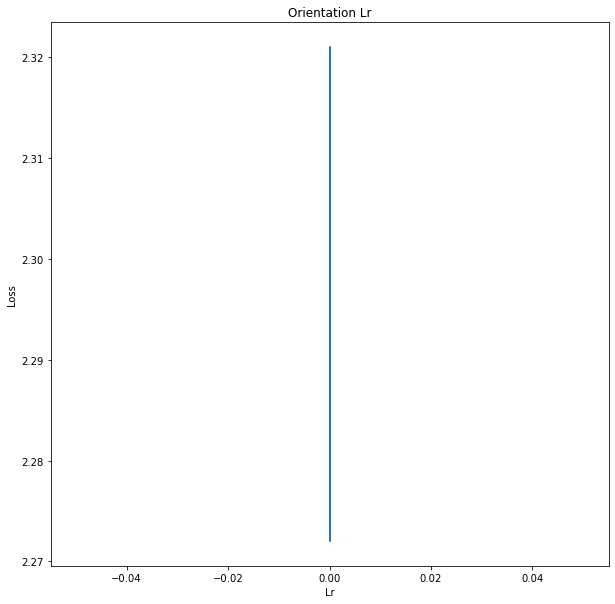

In [133]:

model.train()
lr_scattering =0 
lr = 0
lr_orientation = 0
optimizer = torch.optim.SGD([{'params': params_filters[0], 'lr': lr_orientation },
                                                {'params': [params_filters[1], params_filters[2], params_filters[3]], 
                                                'lr': lr_scattering}, {'params': model.parameters()}],
                                                lr=lr, momentum=0.9,weight_decay=0.0005)
lr = 0
losses =[]
lrs=[]
for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.param_groups[0]['lr'] = lr
    lrs.append(lr)
    data, target = data.to(device), target.to(device, dtype=torch.long)
    optimizer.zero_grad()
    wavelets  = morlets((scattering.M_padded, scattering.N_padded), params_filters[0], 
                        params_filters[1], params_filters[2], params_filters[3], device=device )
    for i,d in enumerate(psi):
        d[0]=wavelets[i].unsqueeze(2).real.contiguous().to(device)   
    data = construct_scattering(data, scattering, psi)
    output = model(data)
    loss = F.cross_entropy(output, target)
    losses.append(loss)
    loss.backward()
    optimizer.step()
    lr*=2
    if lr >10:
        break
plt.figure(figsize=(10,10))
plt.plot( lrs, losses)
plt.title('Orientation Lr')
plt.xlabel('Lr')
plt.ylabel('Loss')   

In [132]:
losses

[tensor(2.3060, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.3042, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.2745, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.3003, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.3150, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.2986, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.2943, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.3224, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.3019, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.3034, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.3072, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.3072, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.3131, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.2987, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.3038, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.3149, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.3110, device='

In [116]:
J = params['scattering']['J']
M, N= params['preprocess']['dimension']['M'], params['preprocess']['dimension']['N']
scattering = Scattering2D(J=J, shape=(M, N))
K = 81*3
model = LinearLayer(K, params['model']['width']).to(device)
if use_cuda:
    scattering = scattering.cuda()
phi, psi  = scattering.load_filters()

#build psi skeleton
psi_skeleton = copy.deepcopy(psi)
for i,d in enumerate(psi_skeleton):
    d[0]=None

if params['model']['mode'] == 'scattering_dif' :
    lr_scattering = params['model']['lr_scattering']  
    lr_orientation = params['model']['lr_orientation']
    params_filters = create_filters_params(J, scattering.L, True,  2)
    wavelets  = morlets((scattering.M_padded, scattering.N_padded,), params_filters[0], params_filters[1], 
                    params_filters[2], params_filters[3], device=device )
    for i,d in enumerate(psi):
        d[0]=wavelets[i] 
    is_scattering_dif = True

/NOBACKUP/gauthiers/kymatio_mod/kymatio/frontend/entry.py:21: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  " version.", DeprecationWarning)


Text(0.5, 1.0, 'Scattering params Lr')

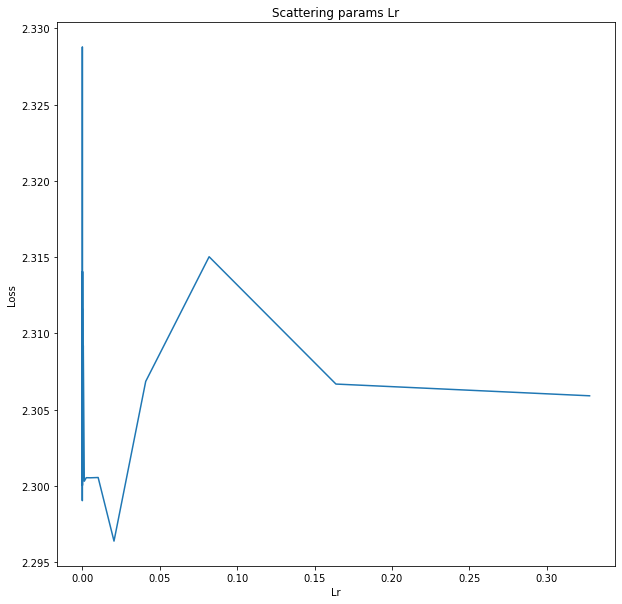

In [117]:
model.train()
lr_scattering =0 
lr = 0
lr_orientation = 0
optimizer = torch.optim.SGD([{'params': params_filters[0], 'lr': lr_orientation },
                                                {'params': [params_filters[1], params_filters[2], params_filters[3]], 
                                                'lr': lr_scattering}, {'params': model.parameters()}],
                                                lr=lr, momentum=0.9,weight_decay=0.0005)
lr = 0.00001
losses =[]
lrs=[]
for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.param_groups[1]['lr'] = lr
    lrs.append(lr)
    data, target = data.to(device), target.to(device, dtype=torch.long)
    optimizer.zero_grad()
    wavelets  = morlets((scattering.M_padded, scattering.N_padded), params_filters[0], 
                        params_filters[1], params_filters[2], params_filters[3], device=device )
    for i,d in enumerate(psi):
        d[0]=wavelets[i].unsqueeze(2).real.contiguous().to(device)   
    data = construct_scattering(data, scattering, psi)
    output = model(data)
    loss = F.cross_entropy(output, target)
    losses.append(loss)
    loss.backward()
    optimizer.step()
    lr*=2
    if lr >2.5:
        break
plt.figure(figsize=(10,10))
plt.plot( lrs, losses)
plt.xlabel('Lr')
plt.ylabel('Loss')
plt.title('Scattering params Lr')
    

In [118]:
J = params['scattering']['J']
M, N= params['preprocess']['dimension']['M'], params['preprocess']['dimension']['N']
scattering = Scattering2D(J=J, shape=(M, N))
K = 81*3
model = LinearLayer(K, params['model']['width']).to(device)
if use_cuda:
    scattering = scattering.cuda()
phi, psi  = scattering.load_filters()

#build psi skeleton
psi_skeleton = copy.deepcopy(psi)
for i,d in enumerate(psi_skeleton):
    d[0]=None

if params['model']['mode'] == 'scattering_dif' :
    lr_scattering = params['model']['lr_scattering']  
    lr_orientation = params['model']['lr_orientation']
    params_filters = create_filters_params(J, scattering.L, True,  2)
    wavelets  = morlets((scattering.M_padded, scattering.N_padded,), params_filters[0], params_filters[1], 
                    params_filters[2], params_filters[3], device=device )
    for i,d in enumerate(psi):
        d[0]=wavelets[i] 
    is_scattering_dif = True

/NOBACKUP/gauthiers/kymatio_mod/kymatio/frontend/entry.py:21: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  " version.", DeprecationWarning)


Text(0.5, 1.0, 'Linear Layer Lr')

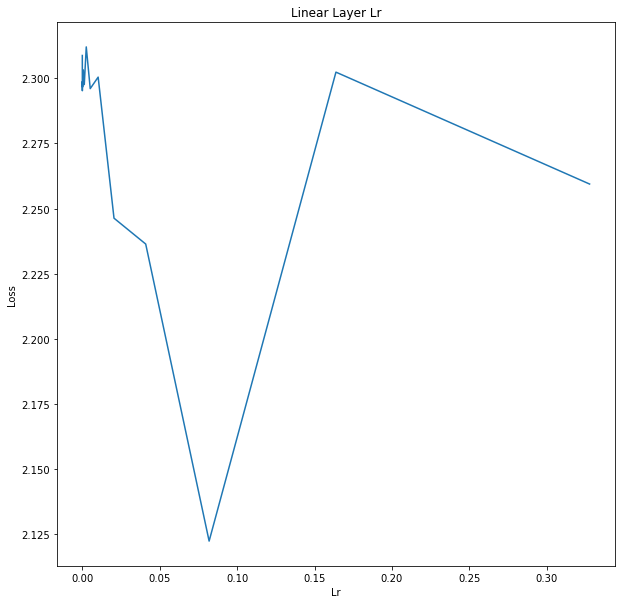

In [119]:
model.train()
lr_scattering =0 
lr = 0
lr_orientation = 0
optimizer = torch.optim.SGD([{'params': params_filters[0], 'lr': lr_orientation },
                                                {'params': [params_filters[1], params_filters[2], params_filters[3]], 
                                                'lr': lr_scattering}, {'params': model.parameters()}],
                                                lr=lr, momentum=0.9,weight_decay=0.0005)
lr = 0.00001
losses =[]
lrs=[]
for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.param_groups[2]['lr'] = lr
    lrs.append(lr)
    data, target = data.to(device), target.to(device, dtype=torch.long)
    optimizer.zero_grad()
    wavelets  = morlets((scattering.M_padded, scattering.N_padded), params_filters[0], 
                        params_filters[1], params_filters[2], params_filters[3], device=device )
    for i,d in enumerate(psi):
        d[0]=wavelets[i].unsqueeze(2).real.contiguous().to(device)   
    data = construct_scattering(data, scattering, psi)
    output = model(data)
    loss = F.cross_entropy(output, target)
    losses.append(loss)
    loss.backward()
    optimizer.step()
    lr*=2
    if lr >2.5:
        break
plt.figure(figsize=(10,10))
plt.plot( lrs, losses)
plt.xlabel('Lr')
plt.ylabel('Loss')
plt.title('Linear Layer Lr')
    